# MobileNetV3

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np
import os


In [2]:
# Define paths to the dataset
train_dir = '../datasets/cinic-10/train'
valid_dir = '../datasets/cinic-10/valid'
test_dir = '../datasets/cinic-10/test'

# Define image size and batch size
image_size = (32, 32)
batch_size = 64

In [3]:
def load_data_from_directory(directory, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    class_names = [class_name for class_name in class_names if class_name != '.DS_Store']
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_file in os.listdir(class_dir):
            if img_file == '.DS_Store':
                continue  # Skip .DS_Store files
            img_path = os.path.join(class_dir, img_file)
            try:
                img = Image.open(img_path).convert('RGB')  # Ensure images are in RGB format
                img = img.resize(target_size)
                img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    # Convert labels to one-hot encoded vectors
    label_map = {label: i for i, label in enumerate(class_names)}
    labels = [label_map[label] for label in labels]
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))
    
    return np.array(images), np.array(labels)


In [4]:

# Load data from directories
pre_train_images, pre_train_labels = load_data_from_directory(train_dir, image_size)
pre_valid_images, pre_valid_labels = load_data_from_directory(valid_dir, image_size)
pre_test_images, pre_test_labels = load_data_from_directory(test_dir, image_size)


In [9]:
# Combine images and labels into a single array
train_data = list(zip(pre_train_images, pre_train_labels))
valid_data = list(zip(pre_valid_images, pre_valid_labels))
test_data = list(zip(pre_test_images, pre_test_labels))

# Shuffle the data
np.random.shuffle(train_data)
np.random.shuffle(valid_data)
np.random.shuffle(test_data)

# Unzip the shuffled data
train_images, train_labels = zip(*train_data)
valid_images, valid_labels = zip(*valid_data)
test_images, test_labels = zip(*test_data)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [6]:
# Load MobileNetV3Large without top classification layer
base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

# Freeze the base model layers
base_model.trainable = False

/Users/salveendutt/GithubRepos/Deep-Learning/.tfenv/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [7]:
# Add additional layers on top of MobileNetV3Large
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')  # Output layer with size 10 for classification
])
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3large (Functional)   │ ?                      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [12]:
# Train the model
history = model.fit(
    train_images, 
    train_labels,
    batch_size=batch_size,
    epochs=10,
    validation_data=(valid_images,valid_labels)
)

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.3233 - loss: 1.8709 - val_accuracy: 0.2230 - val_loss: 2.2444
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 35ms/step - accuracy: 0.3230 - loss: 1.8617 - val_accuracy: 0.1940 - val_loss: 2.6475
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 48s 34ms/step - accuracy: 0.3355 - loss: 1.8304 - val_accuracy: 0.1790 - val_loss: 3.7360
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.3391 - loss: 1.8240 - val_accuracy: 0.2353 - val_loss: 3.4807
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.3454 - loss: 1.8108 - val_accuracy: 0.1847 - val_loss: 2.9041
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.3448 - loss: 1.8077 - val_accuracy: 0.2423 - val_loss: 2.1573
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.3547 - loss: 1.7862 - val_accuracy: 0.2975 - val_loss: 2.0854
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 34ms/step - accuracy: 0.3530 -

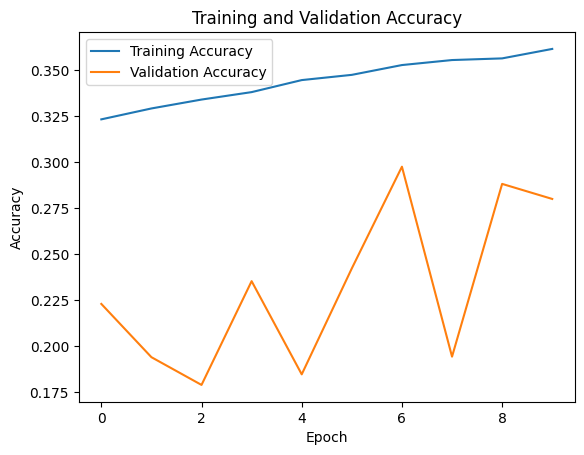

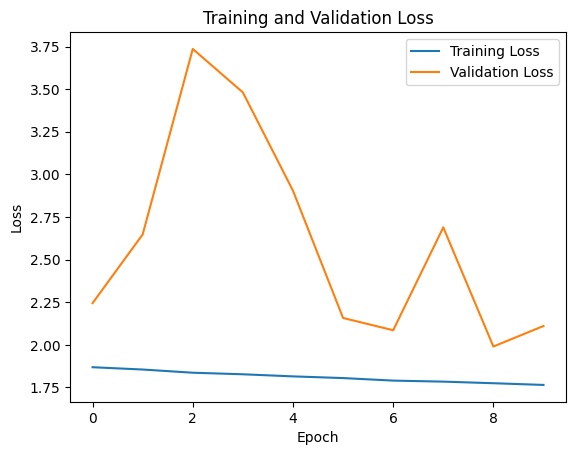

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [14]:
# Predict probabilities for test data
predictions = model.predict(test_images)

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step


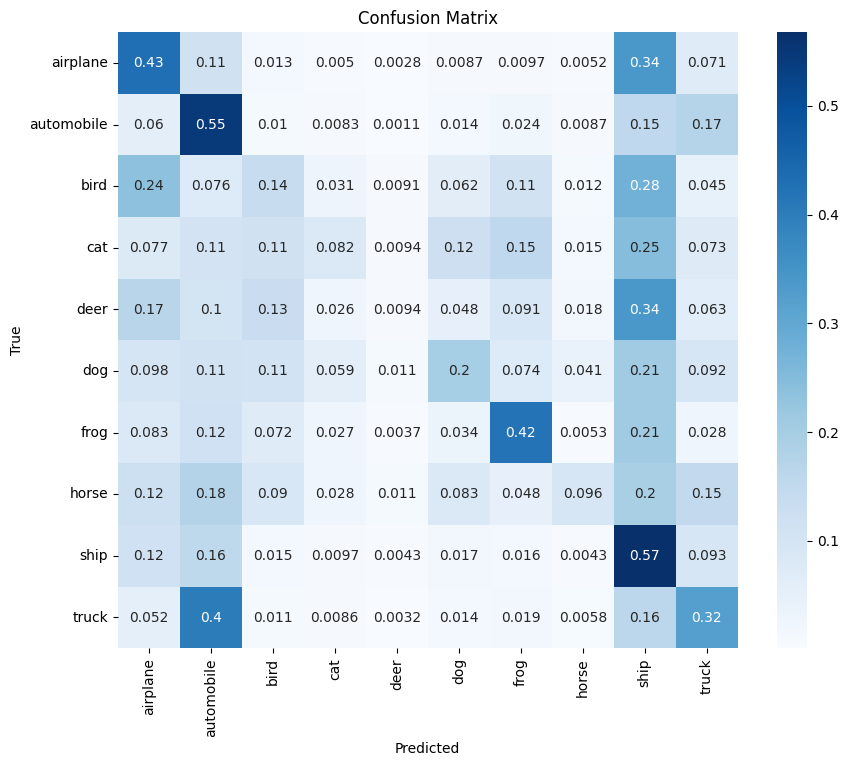

In [15]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = np.argmax(test_labels, axis=1)

# Get class labels
class_labels = sorted(os.listdir(test_dir))
class_labels = [class_name for class_name in class_labels if class_name != '.DS_Store']

# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
